# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
!pip install pandas_profiling

     |████████████████████████████████| 324 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 345 kB 25.7 MB/s eta 0:00:01
     |████████████████████████████████| 679 kB 58.1 MB/s eta 0:00:01
     |████████████████████████████████| 296 kB 50.7 MB/s eta 0:00:01
     |████████████████████████████████| 102 kB 84.4 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 73.7 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 65.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 57.8 MB/s eta 0:00:01
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27085 sha256=cbab9d6b9077a404ae441e8a2e11b02942b9f0b38f3b30915c2332892e1b9541
  Stored in directory: /home/jovyan/.cache/pip/wheels/1d/05/04/c6d7d3b66539d9e659ac6dfe81e2d0fd4c1a8316cc5a403300
Successfully built htmlmin


In [2]:
# Импортируем библиотеки и модули, которые понадобятся нам 
# для решения поставленной задачи
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

/tmp/ipykernel_189/2398274007.py:6: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [3]:
#%%html
#<style>
#body {
#    font-family: "Arial", cursive, sans-serif;
#}
#</style>


С целью упрощения описания полученных результатов введем обозначения регионов: 
1. Регион А;
2. Регион Б;
3. Регион В.

In [4]:
# Определим каждый датафрейм
# Регион А
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
# Регион Б
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
# Регион В
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

### Подготовка данных по региону А

In [5]:
pandas_profiling.ProfileReport(data_0)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# Выведем первые 5 строк датафрейма 
data_0.head(5)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Датафрейм состоит из пяти рядов, один из которых (`id`) текстовый, остальные - числовые (с плавающей запятой). 

In [7]:
# Выведем общую информацию о датафрейме 
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Датафрейм содержит 100 тыс. строк, при этом пропусков в данных нет.

In [8]:
# Выведем описательную статистику
data_0.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,100000,99990,QcMuo,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f0,100000.0,NaN,NaN,NaN,0.500419,0.871832,-1.408605,-0.07258,0.50236,1.073581,2.362331
f1,100000.0,NaN,NaN,NaN,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,NaN,NaN,NaN,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.00379
product,100000.0,NaN,NaN,NaN,92.5,44.288691,0.0,56.497507,91.849972,128.564089,185.364347


Мы видим, что в датафрейме присутствуют повторяющиеся значения в столбце `id`. Так как у нас нет дополнительной информации, позволяющей сделать вывод об актуальности какой-либо записи (в случае, если повтор вызван обновлением данных) или о наличии ошибок в присвоенном id (в случае опечатки оператором), удалим повторяющиеся данные из датафрейма.

In [9]:
# dict_0 = data_0['id'].value_counts().to_dict()
# list_0 = []
# for key in dict_0:
#     if dict_0[key] > 1:
#         list_0.append(key)
# data_0 = data_0.loc[~data_0['id'].isin(list_0)]

In [10]:
data_0 = data_0.drop_duplicates(subset='id', keep=False)
data_0

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


Для обучения модели и оценки ее качества, разобьем данные на тренировочную и валидационную выборки.

In [11]:
data_0_train, data_0_valid = train_test_split(data_0, test_size=0.25, random_state=442)

Очистим тренировочную выборку от выбросов в случае их наличия. 

In [12]:
data_0_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,74985,74985,u5kr8,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f0,74985.0,NaN,NaN,NaN,0.498838,0.8719,-1.408605,-0.075691,0.498718,1.071952,2.33708
f1,74985.0,NaN,NaN,NaN,0.24898,0.504401,-0.848218,-0.201713,0.249481,0.697525,1.343769
f2,74985.0,NaN,NaN,NaN,2.498456,3.247933,-12.088328,0.288714,2.513304,4.706251,16.00379
product,74985.0,NaN,NaN,NaN,92.511726,44.238241,0.004022,56.541679,91.875552,128.521766,185.364347


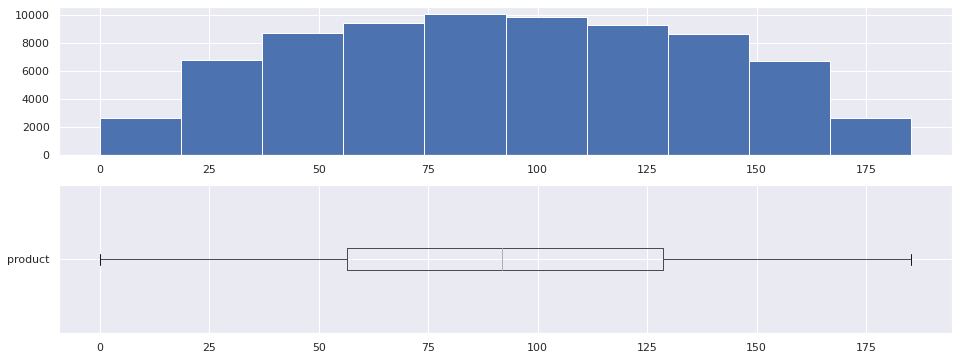

In [13]:
# Определим размер графиков
sns.set(rc={"figure.figsize":(16, 6 )})
# Напишем функцию, выводяющую графики распределения данных
def graph_outlier(data, column):
    fig = plt.figure()
    ax_1 = fig.add_subplot(2, 1, 1)
    data[column].hist();
    ax_2 = fig.add_subplot(2, 1, 2)
    data.boxplot(column, vert=False);

graph_outlier(data_0_train, 'product')

Ряд `product` не имеет выбросов.

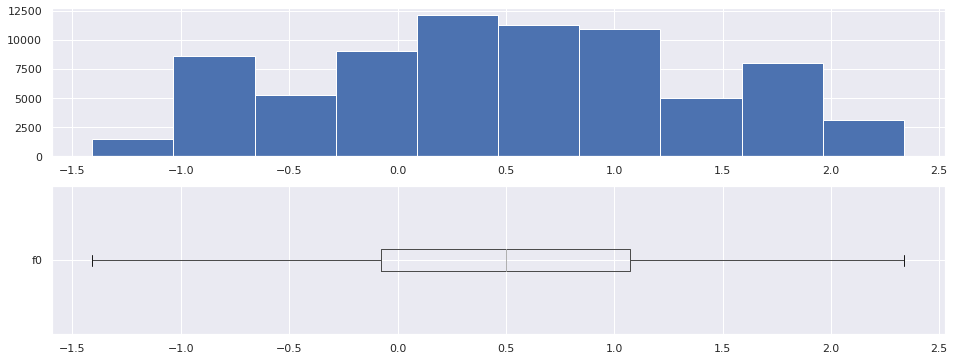

In [14]:
graph_outlier(data_0_train, 'f0')

Ряд `f0` не имеет выбросов.

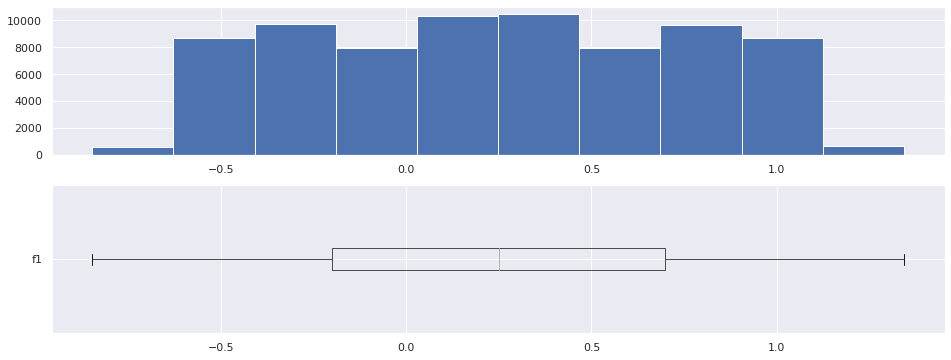

In [15]:
graph_outlier(data_0_train, 'f1')

Ряд `f1` не имеет выбросов.

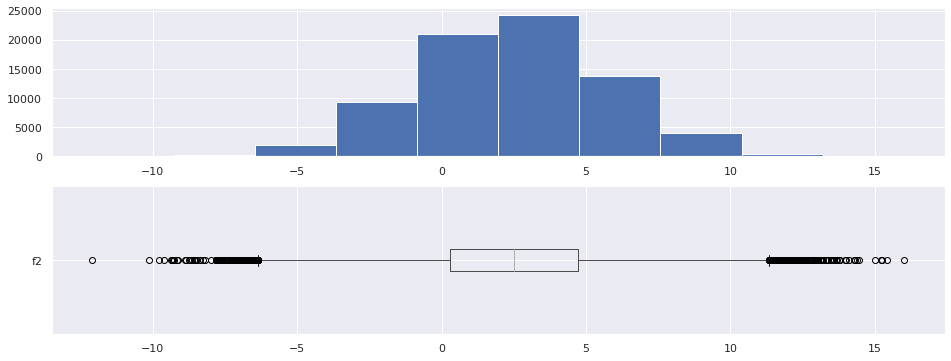

In [16]:
graph_outlier(data_0_train, 'f2')

In [17]:
# Выведем таблицу с выбросами
data_0_train.loc[(data_0_train['f2'] > 11) | (data_0_train['f2'] < -6)]

,id,f0,f1,f2,product
14156,yPeGk,0.675537,0.335520,-6.073731,62.623634
21654,orcI4,0.635486,-0.331524,11.503988,141.473023
3636,N4O8b,1.853945,-0.298831,11.878107,117.508471
47825,mTwzj,0.314252,-0.247253,-6.065522,38.305286
51494,tBn2q,0.921796,0.096376,12.412565,121.512530
...,...,...,...,...,...
55529,83y6j,1.096711,-0.522055,-9.154628,39.679216
7608,VkR9Y,-0.410606,1.015746,11.195482,97.036024
58060,3LmIm,0.189164,-0.074847,-7.478287,99.933325
43911,jeJ2Q,-0.390665,1.016536,-6.364537,42.794073


Ряд `f2` содержит выбросы (568 значений). Для получения более качественной модели удалим выбивающиеся значения (считаем такое решение допустимым, так как доля выбросов в тренировочной выборке составляет менее 0,8%).

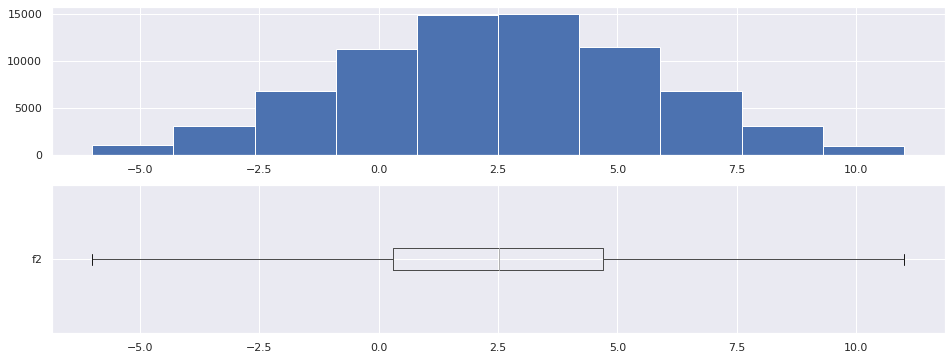

In [18]:
data_0_train = data_0_train.loc[~((data_0_train['f2'] > 11) | 
                                  (data_0_train['f2'] < -6))]
graph_outlier(data_0_train, 'f2')

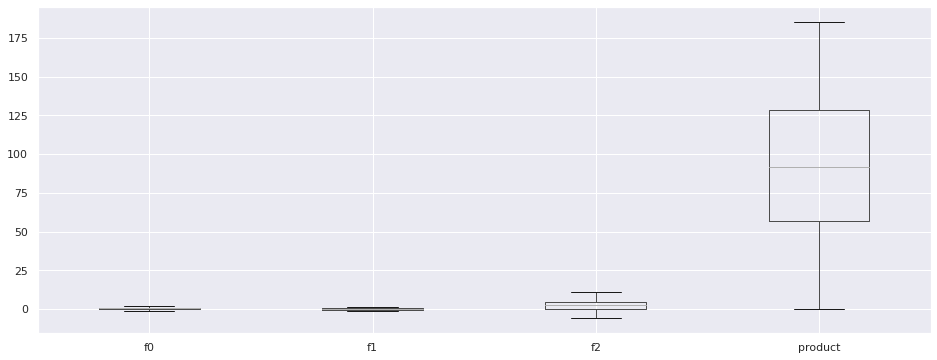

In [19]:
data_0_train.boxplot();

Во время предварительной обработки данных по региону А мы удалили повторяющиеся данные (0,02%), после чего разделили выборку на тренировочную и валидационную. В процессе очистки валидационной выборки от выбросов нами было удалено 568 строк (0,76% размера валидационной выборки), в результате чего ее размер составил 74417 строк.

### Подготовка данных по региону Б

In [20]:
# Выведем первые 5 строк датафрейма 
data_1.head(5)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Датафрейм состоит из пяти рядов, один из которых (`id`) текстовый, остальные - числовые (с плавающей запятой). 

In [21]:
# Выведем общую информацию о датафрейме 
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Датафрейм содержит 100 тыс. строк, при этом пропусков в данных нет.

In [22]:
# Выведем описательную статистику
data_1.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,100000,99996,LHZR0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f0,100000.0,NaN,NaN,NaN,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,NaN,NaN,NaN,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,NaN,NaN,NaN,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,NaN,NaN,NaN,68.825,45.944423,0.0,26.953261,57.085625,107.813044,137.945408


Мы видим, что в датафрейме присутствуют повторяющиеся значения в столбце `id`. Так как у нас нет дополнительной информации, позволяющей сделать вывод об актуальности какой-либо записи (в случае, если повтор вызван обновлением данных) или о наличии ошибок в присвоенном id (в случае опечатки оператором), удалим повторяющиеся данные из датафрейма.

In [23]:
data_1 = data_1.drop_duplicates(subset='id', keep=False)

Для обучения модели и оценки ее качества, разобьем данные на тренировочную и валидационную выборки.

In [24]:
data_1_train, data_1_valid = train_test_split(data_1, test_size=0.25, random_state=442)

Очистим тренировочную выборку от выбросов в случае их наличия. 

In [25]:
data_1_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,74994,74994,TZI5c,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f0,74994.0,NaN,NaN,NaN,1.138114,8.981595,-26.646255,-6.323227,1.169238,8.628559,29.421755
f1,74994.0,NaN,NaN,NaN,-4.792655,5.121967,-26.358598,-8.26931,-4.811093,-1.323364,16.026869
f2,74994.0,NaN,NaN,NaN,2.500411,1.704592,-0.018144,1.000111,2.014769,4.000054,5.019721
product,74994.0,NaN,NaN,NaN,68.981601,45.968418,0.0,30.132364,57.085625,107.813044,137.945408


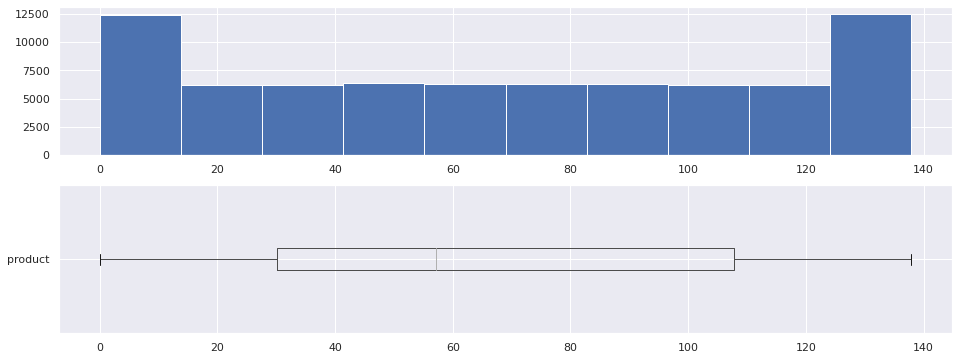

In [26]:
graph_outlier(data_1_train, 'product')

Ряд `product` не имеет выбросов.

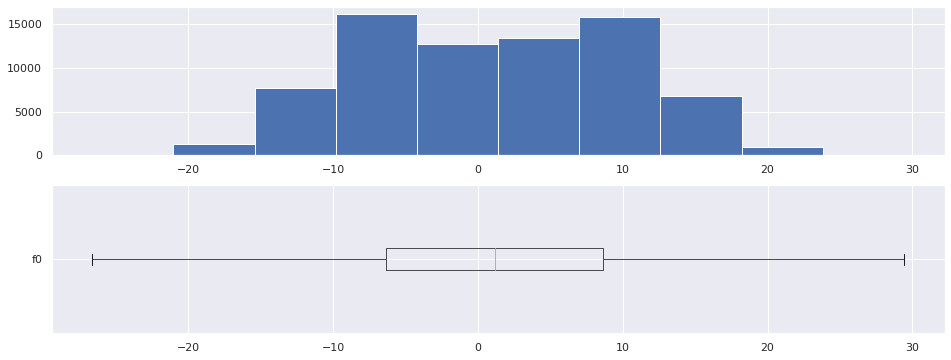

In [27]:
graph_outlier(data_1_train, 'f0')

Ряд `f0` не имеет выбросов.

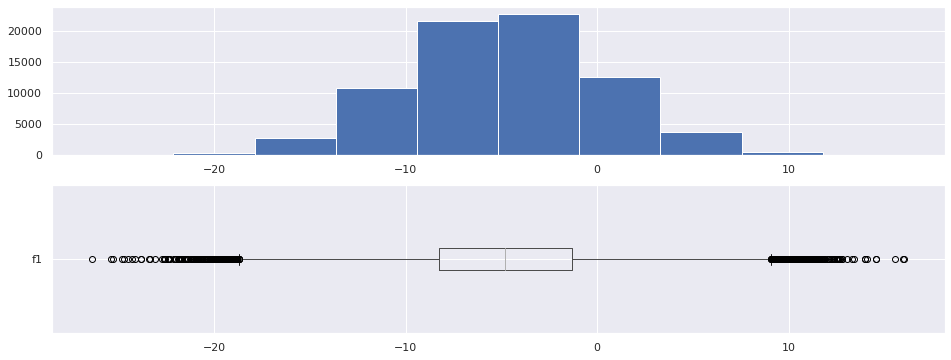

In [28]:
graph_outlier(data_1_train, 'f1')

In [29]:
# Выведем таблицу с выбросами
data_1_train.loc[(data_1_train['f1'] > 8) | (data_1_train['f1'] < -18)]

,id,f0,f1,f2,product
87276,Psgaq,11.422817,8.053461,3.993074,107.813044
2379,r0CI6,-7.281735,-21.837751,-0.004226,3.179103
7893,AQUm0,2.717854,9.397507,1.003779,26.953261
21639,6LbLu,-6.565561,-18.701311,4.005861,110.992147
19982,Dio30,-1.520234,12.362696,2.007729,57.085625
...,...,...,...,...,...
15080,DykM2,7.264831,8.035691,3.000557,80.859783
88119,vkz7N,-1.598019,-26.358598,1.000528,30.132364
41655,FtPL6,-8.985962,-19.550224,4.002317,110.992147
69349,s11qn,8.310259,-20.136473,1.002217,26.953261


Ряд `f1` содержит выбросы (828 значений). Для получения более качественной модели удалим выбивающиеся значения (считаем такое решение допустимым, так как доля выбросов в тренировочной выборке составляет менее 1,2%).

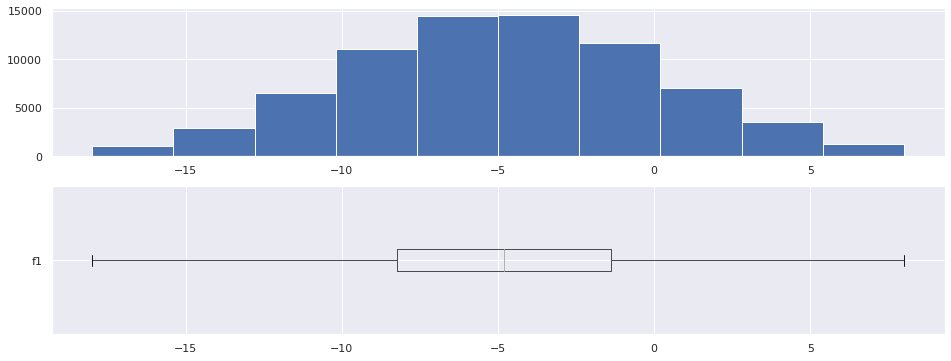

In [30]:
data_1_train = data_1_train.loc[~((data_1_train['f1'] > 8) | 
                                  (data_1_train['f1'] < -18))]
graph_outlier(data_1_train, 'f1')

После преобразований ряд `f1` не имеет выбросов.

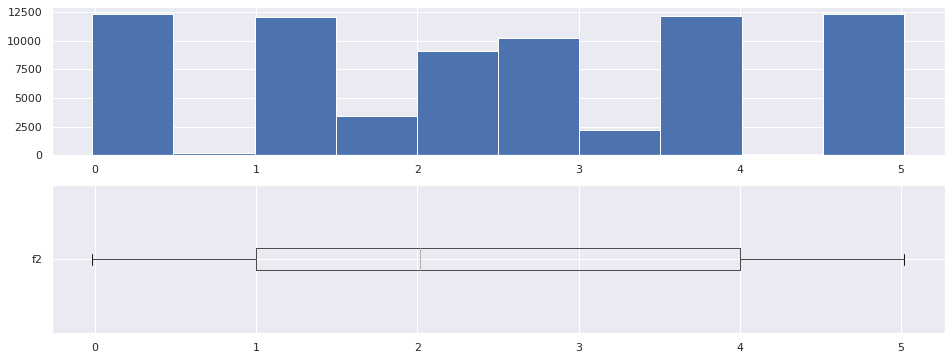

In [31]:
graph_outlier(data_1_train, 'f2')

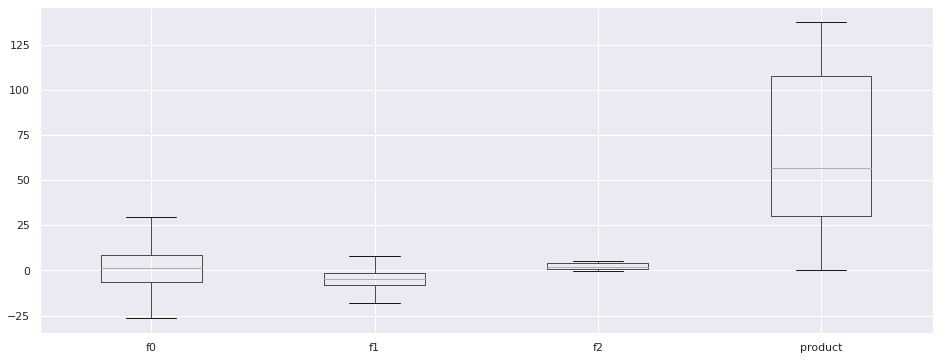

In [32]:
data_1_train.boxplot();

Во время предварительной обработки данных по региону Б мы удалили повторяющиеся данные (0,01%), после чего разделили выборку на тренировочную и валидационную. В процессе очистки валидационной выборки от выбросов нами было удалено 828 строк (1,10% размера валидационной выборки), в результате чего ее размер составил 74166 строк.

### Подготовка данных по региону В

In [33]:
# Выведем первые 5 строк датафрейма 
data_2.head(5)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Датафрейм состоит из пяти рядов, один из которых (`id`) текстовый, остальные - числовые (с плавающей запятой). 

In [34]:
# Выведем общую информацию о датафрейме 
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Датафрейм содержит 100 тыс. строк, при этом пропусков в данных нет.

In [35]:
# Выведем описательную статистику
data_2.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,100000,99996,VF7Jo,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f0,100000.0,NaN,NaN,NaN,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,NaN,NaN,NaN,-0.002081,1.730417,-7.08402,-1.17482,-0.009482,1.163678,7.844801
f2,100000.0,NaN,NaN,NaN,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,NaN,NaN,NaN,95.0,44.749921,0.0,59.450441,94.925613,130.595027,190.029838


Мы видим, что в датафрейме присутствуют повторяющиеся значения в столбце `id`. Так как у нас нет дополнительной информации, позволяющей сделать вывод об актуальности какой-либо записи (в случае, если повтор вызван обновлением данных) или о наличии ошибок в присвоенном id (в случае опечатки оператором), удалим повторяющиеся данные из датафрейма.

In [36]:
data_2 = data_2.drop_duplicates(subset='id', keep=False)

Для обучения модели и оценки ее качества, разобьем данные на тренировочную и валидационную выборки.

In [37]:
data_2_train, data_2_valid = train_test_split(data_2, test_size=0.25, random_state=442)

Очистим тренировочную выборку от выбросов в случае их наличия. 

In [38]:
data_2_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,74994,74994,xAc7F,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f0,74994.0,NaN,NaN,NaN,-0.004489,1.731556,-8.760004,-1.165966,0.001069,1.148614,7.238262
f1,74994.0,NaN,NaN,NaN,-0.005805,1.731778,-7.08402,-1.179663,-0.009369,1.16298,7.844801
f2,74994.0,NaN,NaN,NaN,2.510164,3.471487,-11.61169,0.139079,2.494493,4.873665,16.357645
product,74994.0,NaN,NaN,NaN,95.106418,44.705921,0.0,59.628338,95.078572,130.72715,190.029838


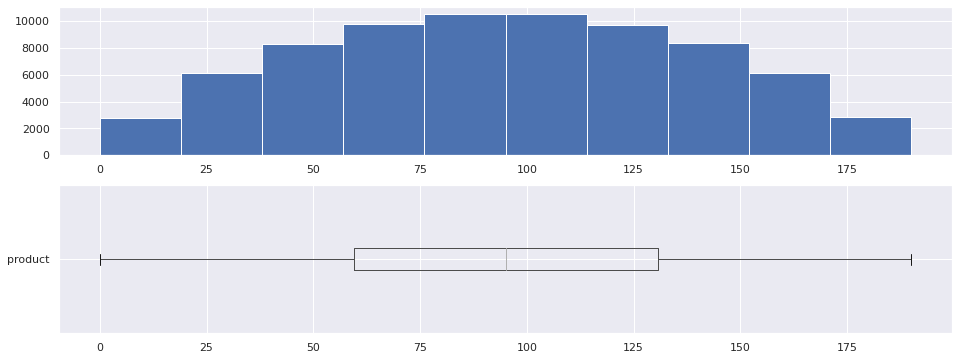

In [39]:
graph_outlier(data_2_train, 'product')

Ряд `product` не имеет выбросов.

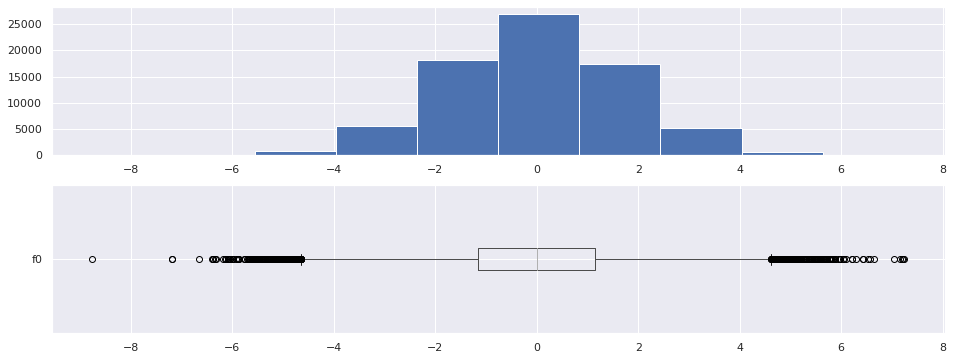

In [40]:
graph_outlier(data_2_train, 'f0')

In [41]:
# Выведем таблицу с выбросами
data_2_train.loc[(data_2_train['f0'] > 4.25) | (data_2_train['f0'] < -4.25)]

,id,f0,f1,f2,product
76937,7w4Bg,4.509450,0.788258,0.105429,30.720166
92957,H4U2A,-5.294862,3.322771,8.823126,186.781379
50935,IpQxB,4.736491,0.712560,2.222608,55.311819
34866,DVzs3,4.275582,0.461462,1.005623,162.541379
70870,maUM5,4.263524,0.714747,8.993723,152.985773
...,...,...,...,...,...
20742,3LjQ4,-4.496049,0.395050,6.054624,103.314778
25492,o7aPf,-6.011832,0.044754,1.898585,131.521780
14480,sfmWl,-4.506140,-0.359513,-2.649688,35.679929
95760,BnQfp,5.082792,0.430748,3.105885,129.149815


Ряд `f0` содержит выбросы (1058 значений). Для получения более качественной модели удалим выбивающиеся значения (считаем такое решение допустимым, так как доля выбросов в тренировочной выборке составляет менее 1,5%).

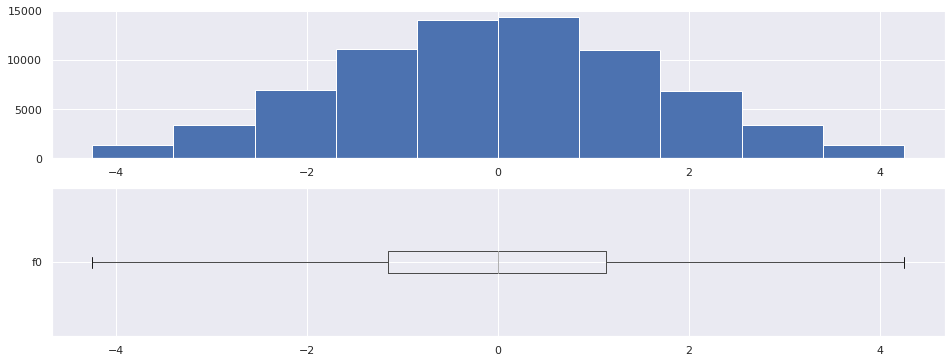

In [42]:
data_2_train = data_2_train.loc[~((data_2_train['f0'] > 4.25) | 
                                  (data_2_train['f0'] < -4.25))]
graph_outlier(data_2_train, 'f0')

После преобразований ряд `f0` не имеет выбросов.

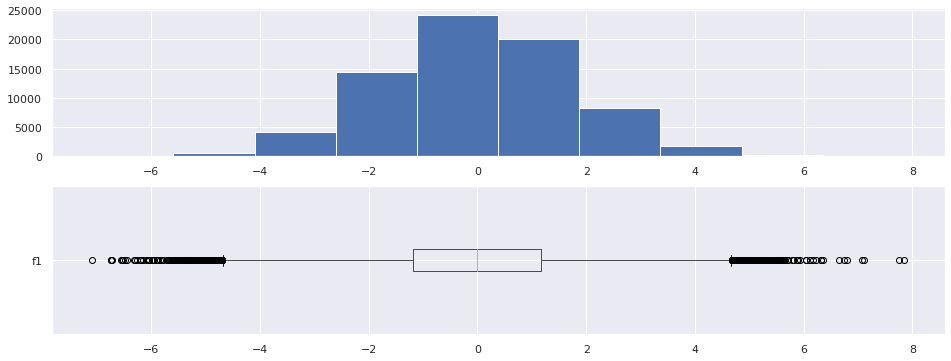

In [43]:
graph_outlier(data_2_train, 'f1')

In [44]:
data_2_train.loc[(data_2_train['f1'] > 4.25) | (data_2_train['f1'] < -4.25)]

,id,f0,f1,f2,product
43816,nDPdf,0.653935,4.857565,3.435320,150.242573
34342,mrbUL,0.698890,-4.392714,0.373611,90.302437
32054,P1SNG,0.057105,-4.635176,2.506073,146.681912
7884,z7S0s,-3.781687,4.918755,6.315466,123.383707
65721,4JSYB,0.117534,-4.278132,6.364787,152.490563
...,...,...,...,...,...
61638,pkAkE,0.368977,4.926513,1.900778,116.255920
53394,HMm6F,1.202145,5.037371,3.489907,129.849217
63408,Uom44,0.496418,4.564016,5.108836,86.895697
24067,nDWYF,0.803114,-6.087158,2.991347,152.455227


Ряд `f0` содержит выбросы (1004 значений). Для получения более качественной модели удалим выбивающиеся значения (считаем такое решение допустимым, так как доля выбросов в тренировочной выборке составляет менее 1,5%).

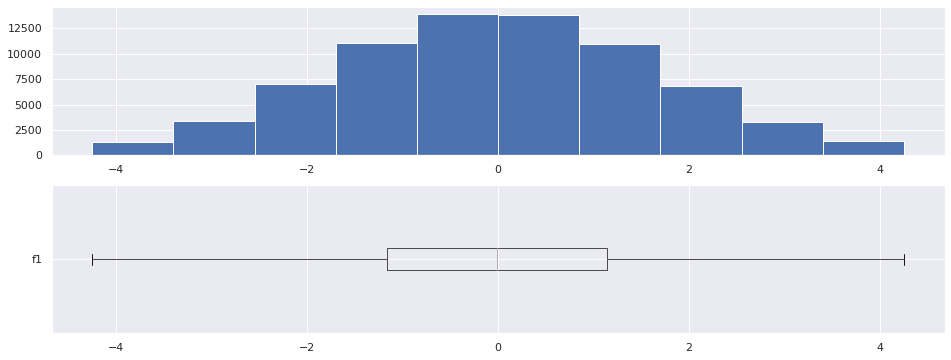

In [45]:
data_2_train = data_2_train.loc[~((data_2_train['f1'] > 4.25) | 
                                  (data_2_train['f1'] < -4.25))]
graph_outlier(data_2_train, 'f1')

После преобразований ряд `f1` не имеет выбросов.

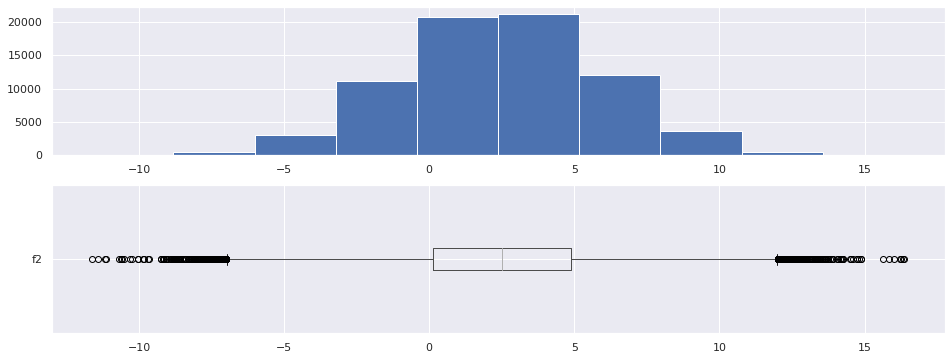

In [46]:
graph_outlier(data_2_train, 'f2')

In [47]:
data_2_train.loc[(data_2_train['f2'] > 11.75) | (data_2_train['f2'] < -6.75)]

,id,f0,f1,f2,product
29149,XQ5CG,1.890123,1.617629,12.735888,153.534762
20800,HlKsn,-1.765239,-0.187340,12.812932,130.035104
53518,1ll4j,0.256727,-0.198443,12.113020,135.104318
38327,XQKr7,-0.513585,-0.654378,-7.001216,53.810152
68925,s8sYk,-1.146758,-1.347558,-8.439788,34.692550
...,...,...,...,...,...
93286,hJutl,-0.455533,0.083982,13.277754,114.324197
3924,lk5bV,2.212752,-1.179772,12.995289,155.107968
64063,IIH9t,0.766028,-1.779145,11.765785,154.116590
49250,zJDEU,0.049147,2.430505,11.888048,185.228664


Ряд `f2` содержит выбросы (517 значений). Для получения более качественной модели удалим выбивающиеся значения (считаем такое решение допустимым, так как доля выбросов в тренировочной выборке составляет менее 0,7%).

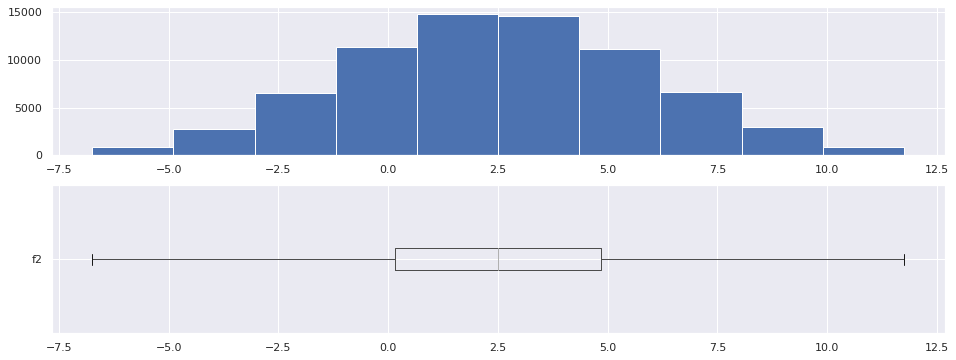

In [48]:
data_2_train = data_2_train.loc[~((data_2_train['f2'] > 11.75) | 
                                  (data_2_train['f2'] < -6.75))]
graph_outlier(data_2_train, 'f2')

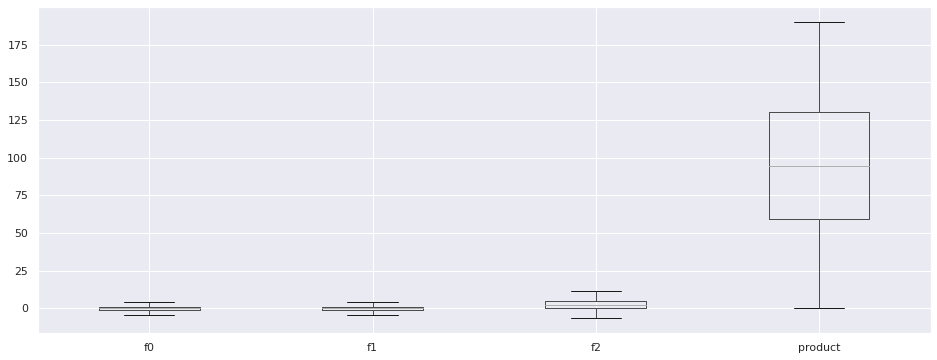

In [49]:
data_2_train.boxplot();

Во время предварительной обработки данных по региону Б мы удалили повторяющиеся данные (0,01%), после чего разделили выборку на тренировочную и валидационную. В процессе очистки валидационной выборки от выбросов нами было удалено 2579 строк (3,43% размера валидационной выборки), в результате чего ее размер составил 72415 строк.

По завершении предварительной оброботки данных мы получили валидационную и тренировочные выборки для каждого исследуемого региона, при этом данные в валидационной выборке очищены от выбросов.

## Обучение и проверка модели

### Регион А

In [50]:
# Объявляем модель, с помощью которой будем строить прогноз
model = LinearRegression()

# Задаем определяющие (features) и определяемые (target) 
# признаки для каждой выборки:
features_train_0 = data_0_train.drop(columns = ['product', 'id'])
target_train_0 = data_0_train['product']
features_valid_0 = data_0_valid.drop(columns = ['product', 'id'])
target_valid_0 = data_0_valid['product']

# Обучаем модель на тренировочной выборке
model.fit(features_train_0, target_train_0)

# Строим прогноз на валидационной выборке
predicted_valid_0 = model.predict(features_valid_0)
# Преобразуем список прогнозных значений в ряд,
# используя индексы определяемого признака на валидационной выборке
predicted_valid_0 = pd.Series(predicted_valid_0, 
                              index=target_valid_0.index)

# Рассчитываем среднюю квадратическую ошибку
mse_0 = mean_squared_error(target_valid_0, predicted_valid_0, squared=False)
print(f'Средний запас предсказанного сырья для региона А составил '
      f'{predicted_valid_0.mean():.5} тыс. баррелей.','\n'
      f'Корень из средней квадратической ошибки (RMSE) составил '
      f'{mse_0:.5} тыс. баррелей.')

Средний запас предсказанного сырья для региона А составил 92.584 тыс. баррелей. 
Корень из средней квадратической ошибки (RMSE) составил 37.847 тыс. баррелей.


### Регион Б

In [51]:
# Задаем определяющие (features) и определяемые (target) 
# признаки для каждой выборки:
features_train_1 = data_1_train.drop(columns = ['product', 'id'])
target_train_1 = data_1_train['product']
features_valid_1 = data_1_valid.drop(columns = ['product', 'id'])
target_valid_1 = data_1_valid['product']

# Обучаем модель на тренировочной выборке
model.fit(features_train_1, target_train_1)

# Строим прогноз на валидационной выборке
predicted_valid_1 = model.predict(features_valid_1)
# Преобразуем список прогнозных значений в ряд,
# используя индексы определяемого признака на валидационной выборке
predicted_valid_1 = pd.Series(predicted_valid_1, 
                              index=target_valid_1.index)

# Рассчитываем среднюю квадратическую ошибку
mse_1 = mean_squared_error(target_valid_1, predicted_valid_1, squared=False)
print(f'Средний запас предсказанного сырья для региона Б составил '
      f'{predicted_valid_1.mean():.5} тыс. баррелей.','\n'
      f'Корень из средней квадратической ошибки (RMSE) составил '
      f'{mse_1:.3} тыс. баррелей.')

Средний запас предсказанного сырья для региона Б составил 68.344 тыс. баррелей. 
Корень из средней квадратической ошибки (RMSE) составил 0.894 тыс. баррелей.


### Регион В

In [52]:
# Задаем определяющие (features) и определяемые (target) 
# признаки для каждой выборки:
features_train_2 = data_2_train.drop(columns = ['product', 'id'])
target_train_2 = data_2_train['product']
features_valid_2 = data_2_valid.drop(columns = ['product', 'id'])
target_valid_2 = data_2_valid['product']

# Обучаем модель на тренировочной выборке
model.fit(features_train_2, target_train_2)

# Строим прогноз на валидационной выборке
predicted_valid_2 = model.predict(features_valid_2)
# Преобразуем список прогнозных значений в ряд,
# используя индексы определяемого признака на валидационной выборке
predicted_valid_2 = pd.Series(predicted_valid_2, 
                              index=target_valid_2.index)

# Рассчитываем среднюю квадратическую ошибку
mse_2 = mean_squared_error(target_valid_2, predicted_valid_2, squared=False)
print(f'Средний запас предсказанного сырья для региона В составил '
      f'{predicted_valid_2.mean():.5} тыс. баррелей.','\n'
      f'Корень из средней квадратической ошибки (RMSE) составил '
      f'{mse_2:.5} тыс. баррелей.')

Средний запас предсказанного сырья для региона В составил 94.368 тыс. баррелей. 
Корень из средней квадратической ошибки (RMSE) составил 40.012 тыс. баррелей.


Мы обучили модели линейной регрессии на данных по каждому региону. Для оценки качества полученного прогноза нами использовалось значение корня среднеквадратического отклонения (RMSE). Преимущества этого показателя заключается в простоте его интерпретации. Значение характеризует, насколько сильно спрогнозированные значения отличаются от фактических, при этом сохраняя единицы измерения анализируемого показателя. 

Наилучший с этой точки зрения прогноз построен для региона Б. Среднее отклонение составило всего 0,894 тыс. баррелей. Стоит отметить, что и средний запас предсказанного сырья в этом регионе наименьший - он составляет 68,344 тыс. баррелей.

Прогнозы по регионам А и В оказались схожи. RMSE по региону А составил 37,847 тыс. баррелей, по региону В - 40,012 тыс. баррелей; средний запас предсказанного сырья составил 92,584 и 94,368 тыс. баррелей соответственно.

## Подготовка к расчёту прибыли

In [53]:
# Объявляем константы, необходимые для расчета прибыли
# Общий бюджет на разработку
TOTAL_BUDGET = 10_000_000_000
# Количество исследуемых скважин
NUMBERS_OF_WELLS = 500
# Количество отобранных скважин
WELLS_FOR_DEV = 200
# Стоимость одного барреля нефти
BARREL_PRICE = 450
# Количество баррелей в одной единице запасов (product) 
QUANTITY_OF_BARREL = 1_000
# Выручка от продажи одной единицы запасов (product)
OIL_REVENUE = BARREL_PRICE * QUANTITY_OF_BARREL

In [54]:
# Рассчитываем минимальный средний запас нефти,
# необходимый для безубыточной добычи
min_avg_prod = TOTAL_BUDGET / OIL_REVENUE / WELLS_FOR_DEV
print(f'Минимальный средний запас нефти в избранных для добычи скважинах '
      f'для достижения точки безубыточности ''\n'
      f'составляет {min_avg_prod:.5} тыс. баррелей.')

Минимальный средний запас нефти в избранных для добычи скважинах для достижения точки безубыточности 
составляет 111.11 тыс. баррелей.


Средний запас нефти в скважине в каждом из исследуемых регионов меньше рассчитанного минимального среднего запаса. При этом необходимо учитывать, что средний запас для каждого региона рассчитан почти для 25 тыс. скважин. Соответственно, возможно существенное отклонение фактического значения от рассчитанного. Таким образом, разработка некоторого количества месторождений, запас в которых отклоняется от среднего значения вверх, может быть прибыльной.

Напишем функцию для расчета потенциальной прибыли от разработки заданного количества месторождений нефти. Это позволит нам оперативно оценивать эффективность разработки при изменении вводных условий.

In [55]:
def profit(target, prediction, count=WELLS_FOR_DEV):
    """
    Функция принимает значения целевого признака и предсказаний 
    на валидационной выборке и возвращает значения прибыли от разработки
    заданного числа скважин в миллирадах рублей.
    """
    data_prod = {'target':target,
                 'prediction':prediction}
    data_prod = pd.concat(data_prod, axis = 1)
    data_prod = data_prod.sort_values(by='prediction', 
                                      ascending=False).iloc[:count]
    production = data_prod['target']
    net_profit = production.sum() * OIL_REVENUE - TOTAL_BUDGET
    return net_profit / 1e+09

## Расчёт прибыли и рисков 

In [56]:
# Написали функцию для проведения процедуры bootstrap
def bootstrap(target, prediction):
    """
    Функция принимает значения целевого признака и предсказаний 
    на валидационной выборке, проводит процедуру Bootstrap и вовзращает
    среднюю прибыль, 5%-й доверительный интервал и риск убытков.
    """
    samples = 1000
    state = np.random.RandomState(442)
    values = []
    for i in range(samples):
        target_subsample = target.sample(n=NUMBERS_OF_WELLS, 
                                         replace=True, 
                                         random_state=state)
        pred_subsample = prediction[target_subsample.index]
        rev_sample = profit(target_subsample, pred_subsample)
        values.append(rev_sample)
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    risk = (values < 0).mean()
    plt.title('Потенциальная прибыль, млрд руб.'),
    plt.axvline(x=lower, ymin=0.00, ymax=0.95, color='red', ls='--', label='2,5%-й квантиль'),
    plt.axvline(x=upper, ymin=0.00, ymax=0.95, color='red', ls='--', label='97,5%-й квантиль'),
    plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
    return (print(f'Средняя прибыль: {values.mean():.3} млрд руб.;'),
            print('Доверительный интервал:'),
            print(f'2,5%-й квантиль: {lower:.2} млрд руб.,'),
            print(f'97,5%-й квантиль: {upper:.3} млрд руб.;'),
            print(f'Риск убытков: {risk:.2%}.'),
            display(values.hist()))

Средняя прибыль: 0.427 млрд руб.;
Доверительный интервал:
2,5%-й квантиль: -0.047 млрд руб.,
97,5%-й квантиль: 0.933 млрд руб.;
Риск убытков: 4.50%.


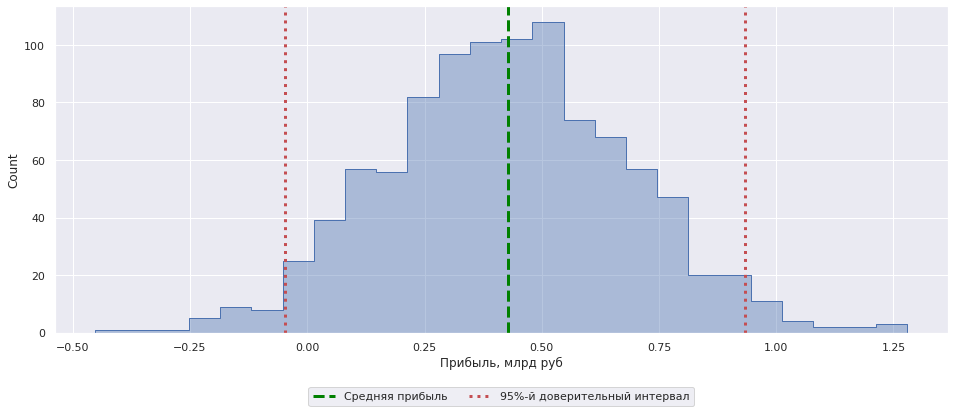

In [64]:
# Написали функцию для проведения процедуры bootstrap
def bootstrap_2(target, prediction):
    """
    Функция принимает значения целевого признака и предсказаний 
    на валидационной выборке, проводит процедуру Bootstrap и вовзращает
    среднюю прибыль, 5%-й доверительный интервал и риск убытков.
    """
    samples = 1000
    state = np.random.RandomState(442)
    values = []
    for i in range(samples):
        target_subsample = target.sample(n=NUMBERS_OF_WELLS, 
                                         replace=True, 
                                         random_state=state)
        pred_subsample = prediction[target_subsample.index]
        rev_sample = profit(target_subsample, pred_subsample)
        values.append(rev_sample)
        
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    risk = (values < 0).mean()
    
    print(f'Средняя прибыль: {values.mean():.3} млрд руб.;'),
    print('Доверительный интервал:'),
    print(f'2,5%-й квантиль: {lower:.2} млрд руб.,'),
    print(f'97,5%-й квантиль: {upper:.3} млрд руб.;'),
    print(f'Риск убытков: {risk:.2%}.')
    
    sns.histplot(values, alpha=0.4,  element="step")
    plt.xlabel('Прибыль, млрд руб')
    plt.axvline(x=values.mean(), color='green', ls='--', lw=3, label='Средняя прибыль')
    plt.axvline(x=lower, color='r', ls=':', lw=3, label='95%-й доверительный интервал')
    plt.axvline(x=upper, color='r', ls=':', lw=3)
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
    plt.show()
    
bootstrap_2(target_valid_0, predicted_valid_0)

### Регион А

Средняя прибыль: 0.427 млрд руб.;
Доверительный интервал:
2,5%-й квантиль: -0.047 млрд руб.,
97,5%-й квантиль: 0.933 млрд руб.;
Риск убытков: 4.50%.


<AxesSubplot:title={'center':'Потенциальная прибыль, млрд руб.'}>

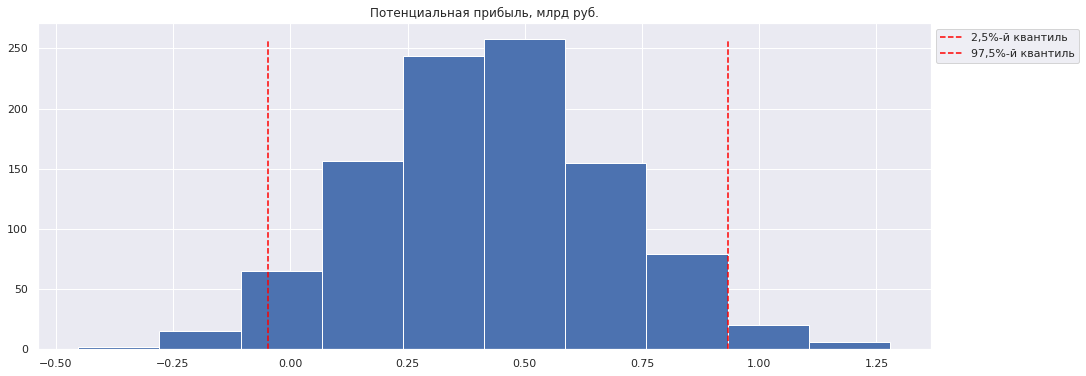

In [60]:
# Рассчитали необходимые показатели для региона А
bootstrap(target_valid_0, predicted_valid_0);

Рассчитанная с помощью процедуры Bootstrap средняя прибыль в регионе А составила 0,427 млрд рублей. При этом с вероятностью 95% значение прибыли будет лежать в границах от -0,047 млрд рублей (убыток) до 0,933 млрд рублей. Риск получить убыток в этом регионе составил 4,5%.

### Регион Б

Средняя прибыль: 0.397 млрд руб.;
Доверительный интервал:
2,5%-й квантиль: 0.017 млрд руб.,
97,5%-й квантиль: 0.79 млрд руб.;
Риск убытков: 1.90%.


<AxesSubplot:title={'center':'Потенциальная прибыль, млрд руб.'}>

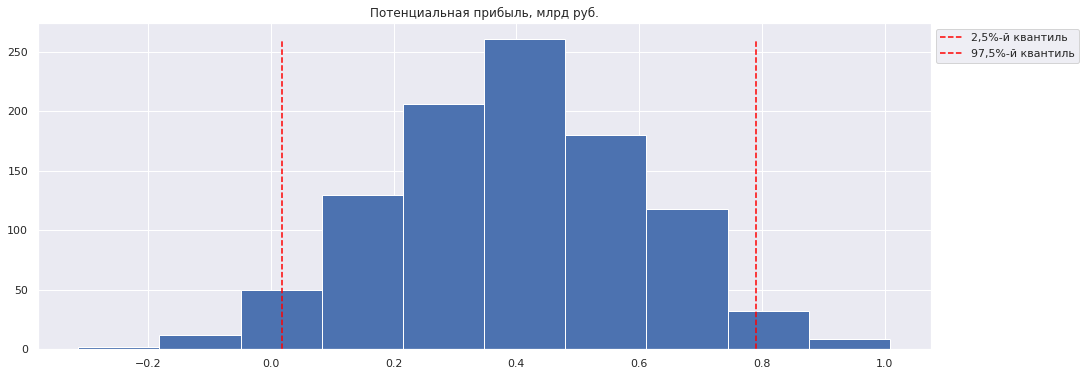

In [61]:
# Рассчитали необходимые показатели для региона Б
bootstrap(target_valid_1, predicted_valid_1);

Рассчитанная с помощью процедуры Bootstrap средняя прибыль в регионе А составила 0,397 млрд рублей. При этом с вероятностью 95% значение прибыли будет лежать в границах от 0,017 млрд рублей до 0,79 млрд рублей. Риск получить убыток в этом регионе составил 1,9%.

### Регион В

Средняя прибыль: 0.383 млрд руб.;
Доверительный интервал:
2,5%-й квантиль: -0.15 млрд руб.,
97,5%-й квантиль: 0.923 млрд руб.;
Риск убытков: 8.30%.


<AxesSubplot:title={'center':'Потенциальная прибыль, млрд руб.'}>

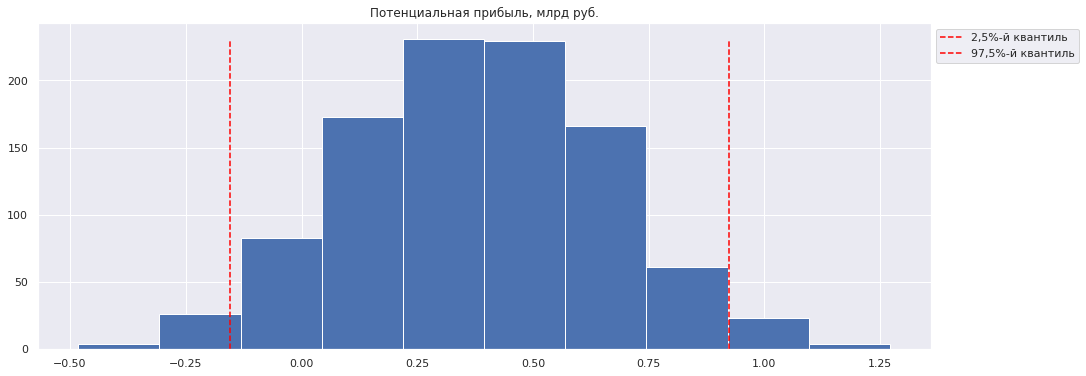

In [62]:
# Рассчитали необходимые показатели для региона В
bootstrap(target_valid_2, predicted_valid_2);

Рассчитанная с помощью процедуры Bootstrap средняя прибыль в регионе А составила 0,383 млрд рублей. При этом с вероятностью 95% значение прибыли будет лежать в границах от -0,15 млрд рублей (убыток) до 0,923 млрд рублей. Риск получить убыток в этом регионе составил 8,3%.

## Вывод

В рамках исследования нами были проанализированы пробы нефти в трех регионах. Мы обучили модель линейной регрессии на данных по каждому региону, оценили качество моделей. Для принятия решения о целесообразности разработки в регионе рассчитали минимальный средний объем запасов, необходимый для безубыточной добычи, а также написали функцию, возвращающую значения прибыли от разработки заданного числа скважин. После этого провели процедуру Bootstrap для каждого региона, что позволило вычислить среднюю прибыль, доверительный интервал и риск убытков.

По расчетам, наибольшая потенциальная прибыль достигается в `регионе А` - 0,427 млрд рублей. Тем не менее, риск убытков в этом регионе составляет 4,5%, что превышает пороговое значение в 2,5%, в следствие чего регион не может быть рекомендован для разработки скважин.

`Регион Б` продемонстрировал вторую по величине потенциальную прибыль - 0,397 млрд рублей. Риск убытков в этом регионе составил 1,9%, что соответствует установленным ограничениям и позволяет рекомендовать регион для разработки скважин.

`Регион В` показал худшую среднюю потенциальную прибыль из всех регионов - 0,383 млрд рублей. При этом риск получить убыток в этом регионе максимальный - 8,3%. Исходя из существующих ограничений, регион не может быть рекомендован для разработки скважин.

Таким образом, формальным признакам, в соответствии с которыми риск убытков должен быть меньше 2,5%, соответствует только `Регион Б`, и именно он рекомендован для разработки нефтяных скважин.
